# Studies on multi-controlled Toffoli decomposition

Valter Uotila, PhD student, University of Helsinki

This is a solution proposal for the Classiq Coding Competition. The problem is decomposing an MCX gate with 14 control qubits into single-qubit and double-qubit CX gates using at most five ancilla qubits. The document has a somewhat essayistic style because I tend to think by writing. Instead of focusing on the problem, I will study it considering the cases in which we do not use ancilla qubits vs. we use up to five ancilla qubits. This comparison should point out how essential ancilla qubits are to implement decompositions. For the case when we do not use ancilla qubits, the circuit becomes unpractically long.

Because number 14 feels an arbitrary number of control qubits and is quite large, this code calculates a possible decomposition for any given number of control qubits depending on the user's input. I base the idea on the [classical book of Niels and Chuang](http://csis.pace.edu/~ctappert/cs837-19spring/QC-textbook.pdf) and the [excellent blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney. Also, the paper [Elementary gates for quantum computation](https://arxiv.org/abs/quant-ph/9503016v1) has been worthwhile. 

When facing this kind of problem, maybe everyone opens first the classical book of Niels and Chuang. One can find there the following exercise:

_**Exercise 4.29: Find a circuit containing $\mathcal{O}(n^2)$ Toffoli, CNOT, and single qubits gates that implement a $C^n(X)$ gate for $n > 3$ using no work qubits.**_

This exercise appears to be surprisingly deep and hard. It is also connected to the problem in the competition, although it does not include the idea of minimal depth. The [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney is about this exercise.

My contribution is the explanation in this document and the implementation that works for any MCX gate. I completed the implementation with Pennylane because it enables recursive structures easily. I use Qiskit to describe and visualize the method.

**Table of contents:**

1. Solution proposal without ancilla qubits
    1. Implementation of a simple function that returns square roots for NOT gate
    2. Iteratively decompose using square root gates
2. Solution proposal with ancilla qubits
    1. Iteratively decompose MCX gates
3. Testing 14 qubits MCX gate with ancilla qubits
4. Is it necessary to be always right?
5. Use ZH-calculus to optimize T-count
    1. Implementation of ZH

In [1]:
import json
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import SXGate, SGate, TGate, IGate, MCXGate

## Solution proposal without ancilla qubits

### Square roots of NOT gate and finding fundamental decompositions with Gidney, Niels and Chuang

As Gidney explains in the [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html), every logical quantum gate has the corresponding square root gate. When we note the fact that diagonal matrices are easy to square and

$$
Z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
$$
we obtain that 
$$
\sqrt[n]{Z} = \begin{bmatrix}
1 & 0 \\
0 & e^{i\frac{\pi}{n}}
\end{bmatrix}.
$$

When we change the computational basis to Hadamard -basis, taking the square roots becomes (at least theoretically) easier: $X = HZH$. That is also why Hadamard-gates in the Classiq's example decomposition in the Classiq's problem description. The $T$-gates and $S$-gates are the certain square roots of $Z$-gate, $T = \sqrt[4]{Z}$ and $S = \sqrt[2]{Z}$. So $T$ and $S$ gates are just a clever way to hide $X$ gates in the decomposition! Gidney reads Niels and Chuang very carefully and notices the power of the following circuit, which corresponds to the Toffoli gate:

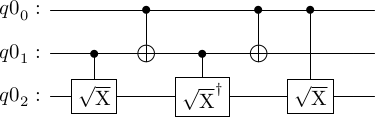

In [2]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.append(SXGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().control(), [qr[0], qr[2]])

circuit.draw(output='latex')

This circuit corresponds to the Toffoli case $V = (1-i)(I+iX)/2$ presented in Figure 4.8 in Niels and Chuang. Furthermore, we can change the basis to Hadamard. Recall that $H\sqrt{X}H = \sqrt{Z} = S$. Thus we can write:

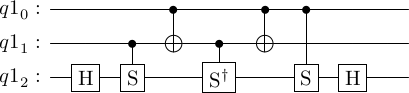

In [3]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)
circuit.append(SGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().control(), [qr[0], qr[2]])
circuit.h(2)

circuit.draw(output='latex')

If one wants a more concrete visualition of the circuit, it is easy [to construct it to Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22Z^%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22Z^-%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22Z^%C2%BD%22],[1,1,%22H%22]]}) (which is, by the way, developed by Gidney) and check that is encodes the Toffoli gate. The circuit also encodes MCX gate when we consider that the first wire is a bundle of multiple wires.

But this construction does not fulfill the requirement of exercise 4.9 nor the competition description since the control bits are attached to the square root and $S$ gates which are not allowed. A careful reading of Niels and Chuang solves this problem. We can express the controlled-square root gates (also $S$ gates) above using the following decomposition presented in Figure 4.6 in Niels and Chuang. After all, this decomposition is quite well known and classical result. For an arbitrary unitary gate $U$, which is controlled by a single qubit, the decomposition is:

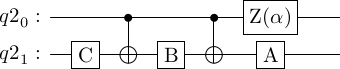

In [4]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.append(IGate(label = "C"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "B"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "A"), [qr[1]])
circuit.append(IGate(label = "Z(\\alpha)"), [qr[0]])

circuit.draw(output='latex')

where
$$
Z(\alpha) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\alpha}
\end{bmatrix}
$$
and $Z(\alpha)AXBXC = U$ and $ABC = I$.

If we compare this construction to Figure 4.9 in Niels and Chuang, we can notice that $A = T$, $B = T^{\dagger}$, $C = I$ and $Z(\alpha) = T$. Now $ABC = TT^{\dagger} = I$ and $e^{(i\alpha)}AXBX = S$. So we can deduce that the following circuit implements the controlled $S$ gate:

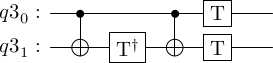

In [5]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.cx(0, 1)
circuit.append(TGate().inverse(), [qr[1]])
circuit.cx(0, 1)
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.draw(output='latex')

When we substitute the above decomposition into the circuit with controlled $S$ gates, we obtain:

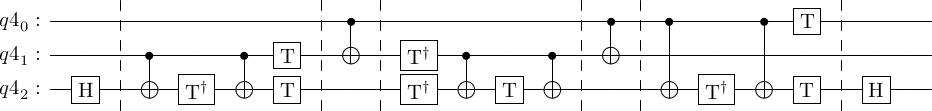

In [6]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

# First substitution
# circuit.append(SGate().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.barrier()


circuit.cx(0, 1)

# Second substitution for inverse S
# circuit.append(SGate().inverse().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.cx(1, 2)
circuit.barrier()

circuit.cx(0, 1)

# Third substitution
#circuit.append(SGate().control(), [qr[0], qr[2]])

circuit.barrier()
circuit.cx(0, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[0]])
circuit.barrier()

circuit.h(2)

circuit.draw(output='latex')

which can be simplied to the following circuit:

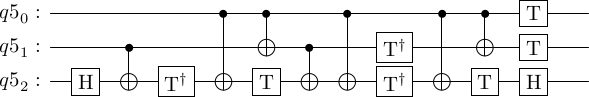

In [7]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])

circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(0, 2)

circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.cx(0, 1)

circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.h(2)

circuit.draw(output='latex')

We see that the depth of this circuit ([see the circuit in Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22],[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22X%22],[1,%22Z^-%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[%22Z^%C2%BC%22,%22Z^%C2%BC%22,%22Z^%C2%BC%22],[1,1,%22H%22]]})) is smaller than the one Niels and Chuang represented but not better than in the Classiq's problem description example. The circuit in the Classiq's problem description has a mistake: the fourth CNOT should be between $q_0$ and $q_2$ not between $q_1$ and $q_2$. The correct circuit is [here](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22%E2%80%A2%22,%22X%22],[1,%22Z^%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22Z^-%C2%BC%22],[%22Z^%C2%BC%22,1,%22H%22],[%22%E2%80%A2%22,%22X%22]]}). The number of gates is the same in all of the circuits.

### Iteratively and automatically decompose larger MCX gates

In this section I code a program that iteratively decomposes MCX gates into the previously represented smaller circuits. Algorithm iteratively removes all the multi-control gates from the circuit expressed in the cell [3]. The circuit in cell [3] does not draw these wires but we consider that the first wire is a bundle of control wires. Pennylane supports badly renaming the qubit unitaries. In the following circuit U gates differ from each other.

C:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\ops\qubit\non_parametric_ops.py:1766: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


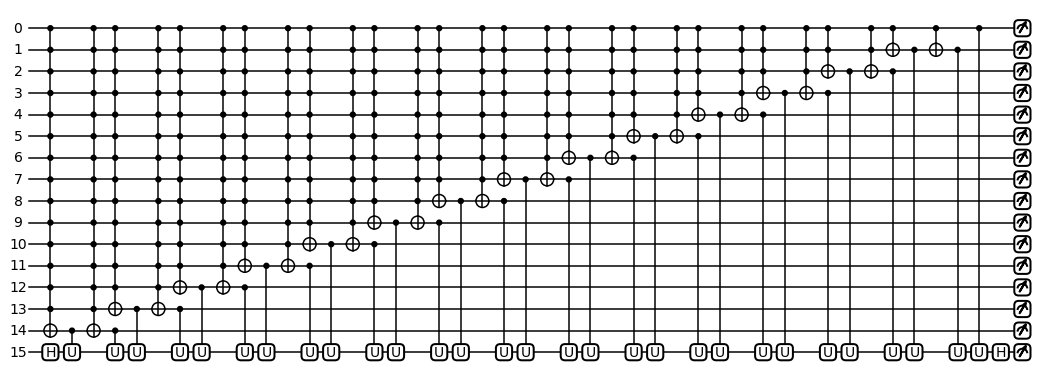

In [8]:
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)

def get_square_root_z(n):
    return np.array([[1, 0], [0, np.exp(1j*np.pi/n)]])
    
@qml.qnode(dev)
def multi_Toffoli_step1_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        square_root_matrix_inv = np.linalg.inv(square_root_matrix)
        
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.ControlledQubitUnitary(square_root_matrix_inv, control_wires = n_ctrl_wires, wires = target)
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.ControlledQubitUnitary(square_root_matrix, control_wires = n_ctrl_wires, wires = target)
    
    qml.ControlledQubitUnitary(square_root_matrix, control_wires = 0, wires = target)
    qml.Hadamard(wires=target)
    return qml.state()

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(multi_Toffoli_step1_circuit, show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next, we decompose the controlled U gates. Here we apply the rule from the cell [5]. Again, the cell [5] shows only the first step of the iteration. We implement the step by decomposing `qml.ControlledQubitUnitary` in the above code. In order to see that the controlled U gates are composed correctly, we can draw the circuit in less pretty but in more informative format.

In [9]:
def controlled_qubit_unitary_decomposed(exponent, n_ctrl_wires, target, adjoint = False):
    square_root_matrix = get_square_root_z(2**exponent)
    square_root_matrix_inv = np.linalg.inv(square_root_matrix)
    
    if adjoint:
        qml.QubitUnitary(square_root_matrix_inv, wires = n_ctrl_wires)
        qml.QubitUnitary(square_root_matrix_inv, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
    else:
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix_inv, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix, wires = target)
        qml.QubitUnitary(square_root_matrix, wires = n_ctrl_wires)
    

In [10]:
@qml.qnode(dev)
def multi_Toffoli_step2_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        #qml.Barrier(wires = range(target + 1))
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = True)
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = False)
        
    #qml.Barrier(wires = range(target +1))
    controlled_qubit_unitary_decomposed(len(all_ctrl_wires[:-1]), 0, target, adjoint = False)
    qml.Hadamard(wires=target)
    return qml.state()

# One can also visualize the code with matplotlib but then the QubitUnatires won't show correctly
# because I was not able to overwrite the default name 'U'
# There might be a fix for this visualization problem

#qml.drawer.use_style('black_white')
#fig, ax = qml.drawer.draw_mpl(multi_Toffoli_step2_circuit, show_all_wires = True, show_matrices=True)(n_ctrl)
#fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)

print(qml.drawer.draw(multi_Toffoli_step2_circuit, show_all_wires=True, decimals=5, max_length=250, show_matrices=True)(n_ctrl))

 0: ─╭C─────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C─────────────────────────────────────────╭C
 1: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 2: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 3: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 4: 

Finally we decompose other MCX gates. Note that with this step we managed to remove one control qubit and we have still MCX gate with 13 control qubits. At each step, the number of required control qubits is reduced by one. Practically this means that we  recirsively execute the above code for each `qml.MultiControlledX`. As one can expect the output circuit is long but it does not use any ancilla qubits.

In [11]:
def multi_Toffoli_step3_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        #qml.Barrier(wires = range(target + 1))
        multi_Toffoli_step3_circuit(n_ctrl_wires - 1)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = True)
        multi_Toffoli_step3_circuit(n_ctrl_wires - 1)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = False)
        
    #qml.Barrier(wires = range(target +1))
    controlled_qubit_unitary_decomposed(len(all_ctrl_wires[:-1]), 0, target, adjoint = False)
    qml.Hadamard(wires=target)

The 14-control qubit MCX gate produces so large circuit that I could not even construct it, so I demonstrate the code with 5-control qubits (which is very long also!). You can uncomment the lines from the below cell.

In [12]:
@qml.qnode(dev)
def multi_Toffoli_final(n_control_wires):
    multi_Toffoli_step3_circuit(n_control_wires)
    return qml.state()

#n_ctrl = 5
#print(qml.drawer.draw(multi_Toffoli_final, show_all_wires=False, decimals=5, max_length=250, show_matrices=True)(n_ctrl))

Even if the circuit is unpractically long to be visualized, we can calculate its depth and gate count easily with Pennylane. The framework offers also other possibly interesting information about the circuit.

In [13]:
# Also command multi_Toffoli_final.qtape.get_depth() might be useful
n_ctrl = 7
print("The specs of " + str(n_ctrl) + " control qubits Toffoli gate without ancilla qubits is: ")
print(json.dumps(qml.specs(multi_Toffoli_final)(n_ctrl), indent=4, sort_keys=True))

The specs of 7 control qubits Toffoli gate without ancilla qubits is: 
{
    "depth": 17012,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "1": 17493,
        "2": 8746
    },
    "gate_types": {
        "CNOT": 8746,
        "Hadamard": 4374,
        "QubitUnitary": 13119
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 15,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 26239,
    "num_trainable_params": 13119,
    "num_used_wires": 9
}


I think this exercise showed how important ancilla qubits are. In some sense they are able to store a lots of information during quantum computations. I did not study this deeper but it seemed that the circuit depth without ancilla qubits is growing exponentially.

## Solution proposal with ancilla qubits

If one studies the 14-control qubit MCX gate a bit, we can easily see that we can decompose it in the following manner. Also, the [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney points out this. See the [Quirk demonstration](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,%22X%22],[1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22,%22%E2%80%A2%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,%22X%22]]}) for 8 control-qubit Toffoli. The idea is that every ancialla qubit divides the construction into two MCX gates which have half of the number of the qubits than the original MCX gate.

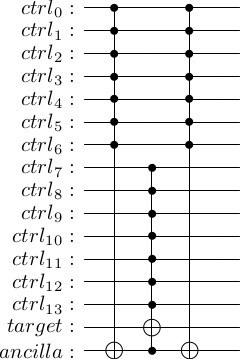

In [14]:
qr = QuantumRegister(14, 'ctrl')
target = QuantumRegister(1, 'target')
anc = QuantumRegister(1, 'ancilla')
circuit = QuantumCircuit(qr, target, anc)

gate7 = MCXGate(7)
gate8 = MCXGate(8)

controls7 = [qr[i] for i in range(7)]
controls8 = [qr[i] for i in range(7, 14)]

circuit.append(gate7, controls7 + [anc[0]])
circuit.append(gate8, controls8 + [anc[0], target[0]])
circuit.append(gate7, controls7 + [anc[0]])

circuit.draw(output='latex')

See the [Quirk example for 12-qubit case](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22]]}) when we use three ancilla qubits and Toffoli gates. Toffoli-gates can be decomposed using the previous decompositions. Let's code the above example with Pennylane:

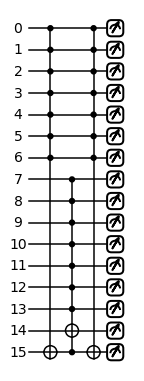

In [15]:
import math
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)

@qml.qnode(dev)
def make_it_half(n_ctrl):
    target = n_ctrl
    ctrl_wires1 = list(range(math.ceil(n_ctrl/2)))
    ctrl_wires2 = list(range(math.floor(n_ctrl/2), n_ctrl)) + [target + 1]
    
    qml.MultiControlledX(control_wires = ctrl_wires1, wires = target + 1)
    qml.MultiControlledX(control_wires = ctrl_wires2, wires = target)
    qml.MultiControlledX(control_wires = ctrl_wires1, wires = target + 1)
    
    return qml.state()

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(make_it_half, wire_order=list(range(target)), show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next we recursively replace `MultiControlledX` until we have expressed everything in terms of Toffoli-gates:

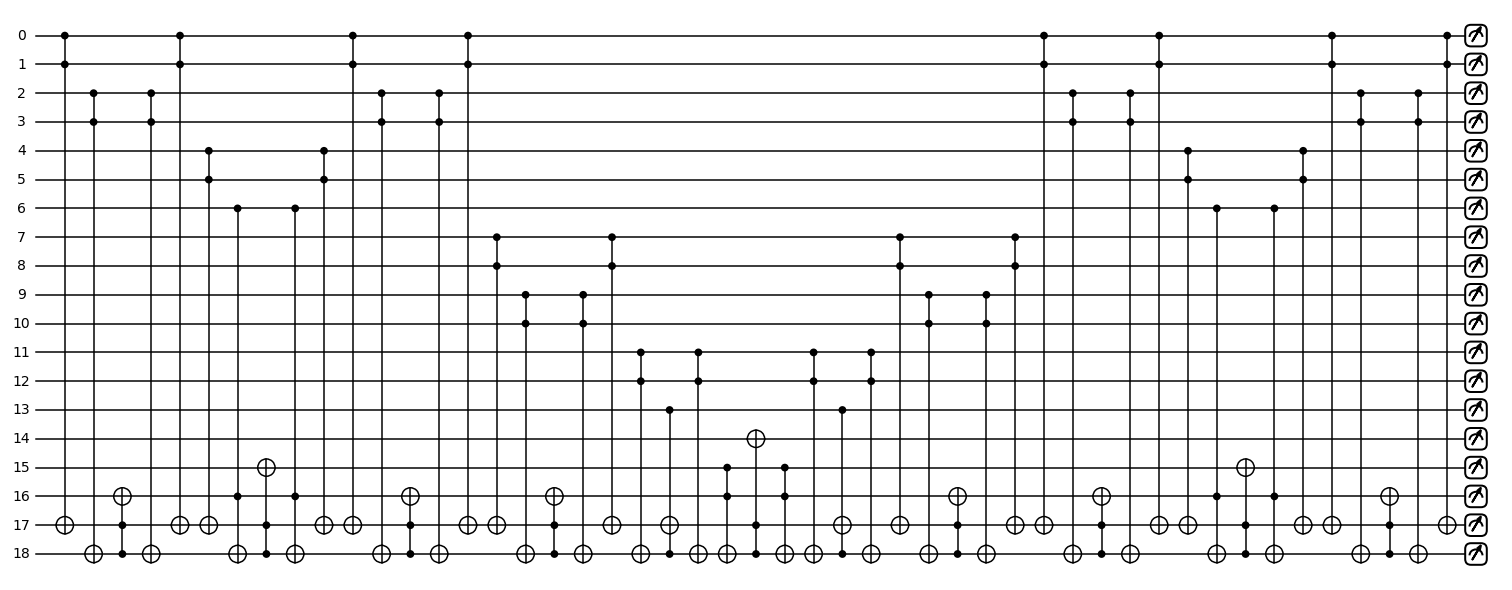

In [16]:
dev = qml.device("default.qubit", wires=20)    

def make_it_half_recursive(ctrl_wires, target):
    n_ctrl = len(ctrl_wires)
    ctrl_indices1 = math.ceil(n_ctrl/2)
    
    if n_ctrl == 1:
        qml.Toffoli(wires = [ctrl_wires[0], target + 1, target])
    elif n_ctrl == 2:
        qml.Toffoli(wires = [ctrl_wires[0], ctrl_wires[1], target])
    else:
        new_target = max(max(ctrl_wires), target)
        make_it_half_recursive(ctrl_wires[:ctrl_indices1], new_target + 1)
        make_it_half_recursive(ctrl_wires[ctrl_indices1:] + [new_target + 1], target)
        make_it_half_recursive(ctrl_wires[:ctrl_indices1], new_target + 1)

@qml.qnode(dev)
def full_algorithm(ctrl_wires, target):
    make_it_half_recursive(ctrl_wires, target)
    return qml.state()

qml.drawer.use_style('black_white')
x = 14
fig, ax = qml.draw_mpl(full_algorithm, wire_order=list(range(20)), show_all_wires = False)(list(range(x)), x)
fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)

In [17]:
print("The specs of 14 control qubits MCX gate with ancilla qubits is: ")
print(json.dumps(qml.specs(full_algorithm)(list(range(14)), 14), indent=4, sort_keys=True))

The specs of 14 control qubits MCX gate with ancilla qubits is: 
{
    "depth": 33,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "3": 49
    },
    "gate_types": {
        "Toffoli": 49
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 20,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 49,
    "num_trainable_params": 0,
    "num_used_wires": 19
}


Next we replace Toffoli-gates with the decomposition from cell [6]:

In [18]:
def toffoli_decomposition(ctrl1, ctrl2, target):
    qml.Hadamard(wires = target)
    qml.CNOT(wires = [ctrl2, target])
    qml.adjoint(qml.T)(wires = target)
    qml.CNOT(wires=[ctrl1, target])
    qml.CNOT(wires=[ctrl1, ctrl2])
    qml.T(wires = target)
    qml.CNOT(wires=[ctrl2, target])
    qml.CNOT(wires=[ctrl1, target])
    qml.adjoint(qml.T)(wires = target)
    qml.adjoint(qml.T)(wires = ctrl2)
    qml.CNOT(wires=[ctrl1, target])
    qml.CNOT(wires=[ctrl1, ctrl2])
    qml.T(wires = target)
    qml.T(wires = ctrl1)
    qml.T(wires = ctrl2)
    qml.Hadamard(wires = target)

In [19]:
dev = qml.device("default.qubit", wires=19)
#dev = qml.device("qiskit.aer", wires=19)

def make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target):
    n_ctrl = len(ctrl_wires)
    ctrl_indices1 = math.ceil(n_ctrl/2)
    
    if n_ctrl == 1:
        toffoli_decomposition(ctrl_wires[0], target + 1, target)
    elif n_ctrl == 2:
        toffoli_decomposition(ctrl_wires[0], ctrl_wires[1], target)
    else:
        new_target = max(max(ctrl_wires), target)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[:ctrl_indices1], new_target + 1)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[ctrl_indices1:] + [new_target + 1], target)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[:ctrl_indices1], new_target + 1)

@qml.qnode(dev)
def final_full_algorithm(ctrl_wires, target):
    make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target)
    return qml.expval(qml.PauliZ(0)) # We measure this because otherwise Qiskit plugin does not create correct OpenQASM

fig, ax = qml.draw_mpl(final_full_algorithm, wire_order=list(range(20)), show_all_wires = False)(list(range(14)), 14)
#fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)
fig.savefig('final_circuit')

To see the circuit properly, see the final_circuit.png file. For some reason the drawer gets lazy and the end of the circuit is not correctly visible. Anyway, there are other options to draw it if necessary.

In [20]:
print("The specs of 14 control qubits Toffoli gate with four ancilla qubits is: ")
print(json.dumps(qml.specs(final_full_algorithm)(list(range(14)), 14), indent=4, sort_keys=True))


# The following code generates OpenQASM for the circuit
# In this case you need to run the circuit on qiskit.awr device since
# Pennylane does not support circuit conversion to OpenQASM

#final_full_algorithm(list(range(14)), 14)
#qasm_circuit = dev._circuit.qasm(formatted  = True, filename = 'toffoli_qasm')

The specs of 14 control qubits Toffoli gate with four ancilla qubits is: 
{
    "depth": 352,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "1": 441,
        "2": 343
    },
    "gate_types": {
        "CNOT": 343,
        "Hadamard": 98,
        "T": 196,
        "T.inv": 147
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 19,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 784,
    "num_trainable_params": 0,
    "num_used_wires": 19
}


## Testing 14 qubits MCX gate with ancilla qubits

We test the code so that we create Hadamard transform over the 14 control qubits. We know that only one state (one containing 14 times $|1\rangle$) among $2^{14}$ produces output 1 when the target qubit is measured. This means that we should measure 1 from the target qubit with the probability $\frac{1}{2^{14}} = 1/16384 = 0.000061035... \approx 6.1035\times 10^{-5}$. Any mistake in the code will affect this result remarkably.

In [21]:
dev = qml.device("lightning.qubit", wires=19)

@qml.qnode(dev)
def test_code(n):
    ctrl_wires, target = list(range(n)), n
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=ctrl_wires)
    #qml.broadcast(unitary=qml.PauliX, pattern="single", wires=ctrl_wires)
    make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target)
    return qml.probs(wires=[target])

print(test_code(14))

[9.99938965e-01 6.10351563e-05]


As we see the output probability to measure 1 is very close to `6.1035e-05`. This indicates that the decomposition is correct.

## Variational classifier: Is it necessary to be always right?

I think this exercise would be a great and sufficiently simple example of variational classifiers. So I modified the exercise to develop a parametrized quantum circuit optimized to simulate the MCX gate. It would work to know that it produces a correct value to the target qubit with a certain probability. The original idea of the variational classifier is demonstrated in [Pennylane's demonstration](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html), which is inspired by papers [Classification with Quantum Neural Networks on Near Term Processors](https://arxiv.org/abs/1802.06002) and [Circuit-centric quantum classifiers](https://arxiv.org/abs/1804.00633). Now the gate depth and gate count depend on our ansatz.

We can actually follow the outline of the demonstration. The demonstration implements variational classifier for the parity function but in our case the function is quite simple too:
$$
f \colon \left\{0,1 \right\}^{14} \to \left\{0,1 \right\}, \text{ where } f(x) = \begin{cases} 1 \text{ if } x_i = 1 \text{ for all } i = 1, \ldots 14 \\
0 \text{ otherwise}\end{cases}
$$
There is plenty of data around now since we know exactly how MCX is supposed to work!

I do not think I have time and resources start training the model for 14 qubits MCX gate so I demonstrate the problem with three control qubits and one target qubit.

In [22]:
from pennylane.optimize import AdamOptimizer

n_ctrl = 4
qubits = n_ctrl
dev = qml.device("default.qubit", wires=qubits)

def layer(W):
    for i in range(qubits - 1):
        qml.CRot(W[i, 0], W[i, 1], W[i, 2], wires = [i, qubits - 1])

The following circuit implements the ansatz for this quantum machine learning task.

In [23]:
@qml.qnode(dev)
def MCToffoli(weights, x):
    
    qml.BasisState(x, wires=range(qubits - 1))

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(qubits - 1))

In [24]:
def variational_classifier(weights, bias, x):
    return MCToffoli(weights, x) #+ bias

In [25]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        #print('Label ', l, ' prediction ', p)
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [26]:
from itertools import combinations
b_strings = []

def genbin(n, bs = []):
    if n-1:
        genbin(n-1, bs + [0])
        genbin(n-1, bs + [1])
    else:
        b_strings.append([1] + bs)
        b_strings.append([0] + bs)

def generate_data(n_items, qubits):
    result = [1 for i in range(qubits-1)]
    Y = [0]
    X = [result]
    
    genbin(qubits-1)
    
    for string in b_strings:
        if not all(string):
            X.append(string)
            Y.append(1)
        
    return np.array(X, requires_grad=False), np.array(Y, requires_grad=False)

In [27]:
n_items = 2^qubits
X, Y = generate_data(n_items, qubits)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

print("Example of generated data: ")
for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

Example of generated data: 
X = [1 1 1], Y = -1
X = [1 0 0], Y =  1
X = [0 0 0], Y =  1
X = [1 0 1], Y =  1
X = [0 0 1], Y =  1


In [28]:
np.random.seed(0)
num_qubits = qubits
num_layers = 10
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [29]:
opt = AdamOptimizer()
batch_size = 5
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

Iter:     1 | Cost: 0.4599114 | Accuracy: 0.8750000 
Iter:     2 | Cost: 0.4238353 | Accuracy: 0.8750000 
Iter:     3 | Cost: 0.3598879 | Accuracy: 0.8750000 
Iter:     4 | Cost: 0.3144206 | Accuracy: 0.8750000 
Iter:     5 | Cost: 0.2946587 | Accuracy: 0.8750000 
Iter:     6 | Cost: 0.2882779 | Accuracy: 0.8750000 
Iter:     7 | Cost: 0.2879778 | Accuracy: 0.8750000 
Iter:     8 | Cost: 0.2991846 | Accuracy: 0.8750000 
Iter:     9 | Cost: 0.3251705 | Accuracy: 0.8750000 
Iter:    10 | Cost: 0.3131737 | Accuracy: 0.8750000 
Iter:    11 | Cost: 0.2857538 | Accuracy: 0.8750000 
Iter:    12 | Cost: 0.2552789 | Accuracy: 0.8750000 
Iter:    13 | Cost: 0.2318612 | Accuracy: 0.8750000 
Iter:    14 | Cost: 0.2287313 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.2514399 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.2978780 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.3399773 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.3725338 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.3745355 | Accuracy: 1.00

In [30]:
#print(weights)

[1, 0, 0]
0.955342906510348

[0, 0, 0]
1.0

[1, 0, 1]
0.9660981728476242

[0, 0, 1]
0.8954764505168644

[1, 1, 0]
0.8355921761369804

[0, 1, 0]
0.8960909489826223

[1, 1, 1]
-0.8120762391615083

[0, 1, 1]
0.8079583076356955



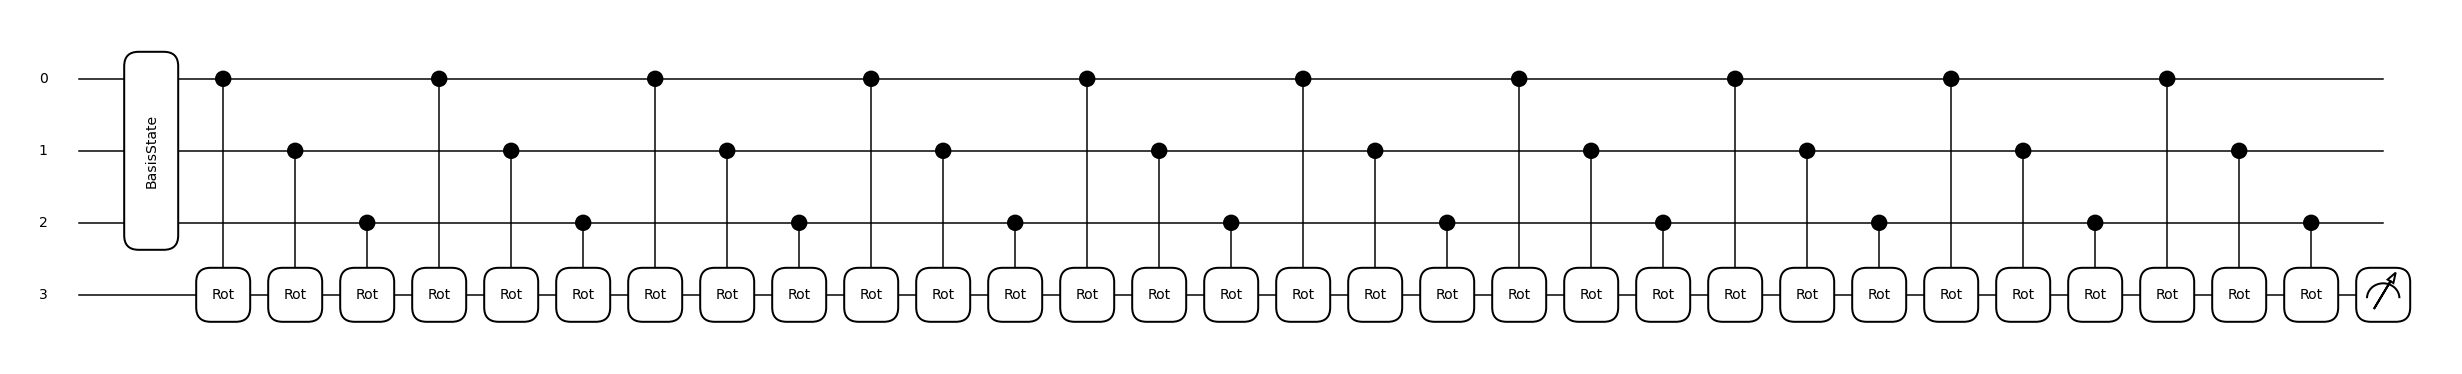

In [31]:
qml.draw_mpl(MCToffoli)(weights, np.array([1,1,1]))
for b in b_strings:
    print(b)
    print(MCToffoli(weights, np.array(b)))
    print()

In [32]:
# We create the same circuit as we used in the model except that we measure the target qubit
@qml.qnode(dev)
def MCToffoli2(weights, x):
    
    qml.BasisState(x, wires=range(qubits - 1))

    for W in weights:
        layer(W)

    return qml.probs(wires=qubits - 1)

In [33]:
# If any of three control qubits is 0, we measure 0 with high probability
x = np.array([0,0,0])
print(MCToffoli2(weights, x))

# If three control qubits are 1, we measure 1 with high probability
x = np.array([1,1,1])
print(MCToffoli2(weights, x))

[1. 0.]
[0.09396188 0.90603812]
